## ДЗ
Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt
(1 балл)

Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)
(3 балла)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt
(2 балла)

Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая
(2 балла)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

In [8]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def groups_splitter(df, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

In [2]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

<Axes: xlabel='cart_added_cnt', ylabel='Count'>

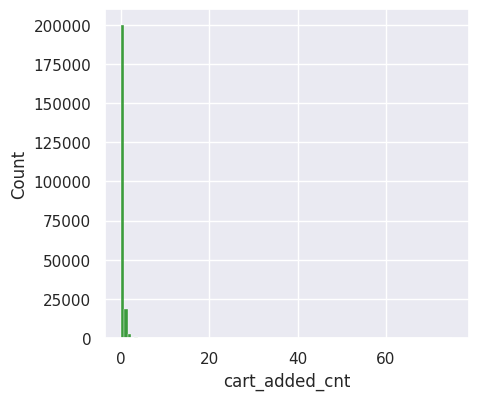

In [156]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

#### Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:

* метрике cart_added_cnt (1 балл)

In [157]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [158]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

In [159]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

t-test не нашел различий в двух группах

In [160]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

Критерий Манна-Уитни показал такой же результат

In [161]:
def check_uniform(p_values):
    stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

    if p_value < 0.05:
        print(f'p_value = {p_value} - p_values неравномерное распределение')
    else:
        print(f'p_value = {p_value} - p_values равномерное распределение')

Посмотрим на мощность:

In [162]:
shop = shop_metrics_new.drop(columns=['group'])

In [173]:
correctness = []
power = []

correctness_mw = []
power_mw = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05

    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    p_cor_mw, p_power_mw = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a_power, vec_b_power)[1]

    correctness.append(p_cor)
    power.append(p_power)

    correctness_mw.append(p_cor_mw)
    power_mw.append(p_power_mw)

correctness = np.array(correctness)
correctness_mw = np.array(correctness_mw)

sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
power_mw = np.array(power_mw)

check_uniform(correctness)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Мощность критерия Манну-Уитни:

p_value = 0.3517367037695362 - p_values равномерное распределение
power: 100.0% , correctness: 94.0%


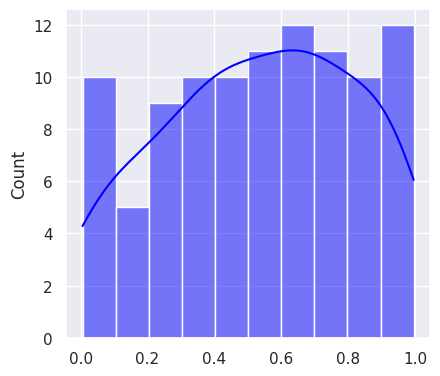

In [164]:
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness_mw, bins=10, color='blue', kde=True)

check_uniform(correctness_mw)
print(f'power: {(power_mw[power_mw < 0.05].shape[0] / power_mw.shape[0]) * 100}% , correctness: {(1 - (correctness_mw[correctness_mw < 0.05].shape[0] / correctness_mw.shape[0])) * 100}%')

Мощность и корректность критериев также равны

#### Реализовать cuped-трансформацию и сравнить мощность t-критерия на:

* обычной метрике cart_added_cnt
* логарфимированной метрике cart_added_cnt
* метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (3 балла)

In [165]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [166]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

In [167]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [168]:
shop_metrics_all_cuped.head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761


Сравним средние в измененной метрике и дисперсии:


In [169]:
def print_group_mean_var(df, metric):
    group_a_var = df[df.group == "A"][metric].var()
    group_b_var = df[df.group == "B"][metric].var()
    group_a_cuped_var = df[df.group == "A"][f"{metric}_cuped"].var()
    group_b_cuped_var = df[df.group == "B"][f"{metric}_cuped"].var()

    group_a_mean = df[df.group == "A"][metric].mean()
    group_b_mean = df[df.group == "B"][metric].mean()
    group_a_cuped_mean = df[df.group == "A"][f"{metric}_cuped"].mean()
    group_b_cuped_mean = df[df.group == "B"][f"{metric}_cuped"].mean()

    print('Сравним средние:')
    print(f"метрика_cuped A: {group_a_cuped_mean}, метрика_cuped B: {group_b_cuped_mean}")
    print(f"метрика без cuped A: {group_a_mean}, метрика без cuped B: {group_b_mean}")
    print('\nСравним дисперсии:')
    print(f"метрика_cuped A: {group_a_cuped_var}, метрика_cuped B: {group_b_cuped_var}")
    print(f"метрика без cuped A: {group_a_var}, метрика без cuped B: {group_b_var}")
    print(f"разница метрика A и метрика_cuped A: {group_a_var - group_a_cuped_var}")
    print(f"разница метрика B и метрика_cuped B: {group_b_var - group_b_cuped_var}")

In [171]:
print_group_mean_var(shop_metrics_all_cuped, 'cart_added_cnt')

Сравним средние:
метрика_cuped A: 0.136382315726573, метрика_cuped B: 0.1372102898471418
метрика без cuped A: 0.1350419058398685, метрика без cuped B: 0.1385521582733813

Сравним дисперсии:
метрика_cuped A: 0.01823518359964534, метрика_cuped B: 0.02149536345539653
метрика без cuped A: 0.3805867322090304, метрика без cuped B: 0.4247189893567569
разница метрика A и метрика_cuped A: 0.36235154860938507
разница метрика B и метрика_cuped B: 0.40322362590136035


Среднии сохранились, дисперсии сильно сократилась

Проверим, как на измененной метрике покажет себя t-test:


In [108]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128447498, pvalue=0.16587364048767594, df=222519.0)

t-test также указывает на отсутствие значимых различий, p_value сократился, но не сильно

Посмотрим на мощность при эффекте в 3%

100%|██████████| 100/100 [02:47<00:00,  1.67s/it]


p_value = 0.93527347532985 - p_values равномерное распределение
 power: 100.0% , correctness: 97.0%


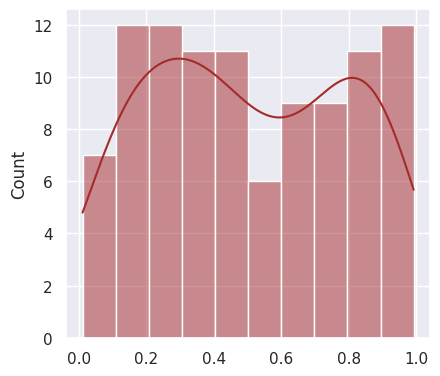

In [175]:
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.03


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
check_uniform(correctness)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

##### Перейдем к логарифмированию

In [144]:
# прологорифмируем
shop_metrics_all['cart_added_cnt_ln'] = np.log(shop_metrics_all['cart_added_cnt'] + 1)
shop_metrics_all['cart_added_cnt_ln_covariate'] = np.log(shop_metrics_all['cart_added_cnt_covariate'] + 1)

# трансформируем метрику
shop_metrics_all_ln_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt_ln'])

In [152]:
# посмотрим на t-test
stats.ttest_ind(shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'A']['cart_added_cnt_ln'],
                shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'B']['cart_added_cnt_ln'])

TtestResult(statistic=-1.4539361335316499, pvalue=0.14596542412011718, df=222519.0)

Логарифмирование снизило p_value, но группы по прежнему не имеют значимых отличий

Сравним средние в измененной метрике и дисперсии:

In [170]:
print_group_mean_var(shop_metrics_all_ln_cuped, 'cart_added_cnt_ln')

Сравним средние:
метрика_cuped A: 0.08034157852348373, метрика_cuped B: 0.08072086382541538
метрика без cuped A: 0.07974289062640032, метрика без cuped B: 0.08132020317245879

Сравним дисперсии:
метрика_cuped A: 0.002055014378642915, метрика_cuped B: 0.0017558187333519104
метрика без cuped A: 0.06466232955752058, метрика без cuped B: 0.06628259108478471
разница метрика A и метрика_cuped A: 0.06260731517887766
разница метрика B и метрика_cuped B: 0.0645267723514328


Средние сохранились, а дисперсии сократились => понимаем, почему снизился p-value

Посмотрим на мощность:

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


p_value = 0.8291224794984855 - p_values равномерное распределение
 power: 100.0% , correctness: 96.0%


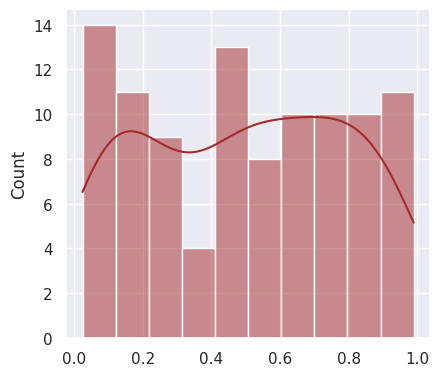

In [181]:
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    all_df['cart_added_cnt_ln'] = np.log(all_df['cart_added_cnt'] + 1)
    all_df['cart_added_cnt_ln_covariate'] = np.log(all_df['cart_added_cnt_covariate'] + 1)

    cuped_df = cuped_transform(all_df, ['cart_added_cnt_ln'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_ln_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_ln_cuped']
    vec_b_effect = vec_b * np.log(1.03)

    # vec_b_effect_ln = np.log(vec_b_effect + 1)

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
check_uniform(correctness)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

##### Реализовать cuped-трансформацию на метрике cart_added_cnt и подвергнем ее ранговому преобразованию

In [182]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

ranked = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
                             shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped')

In [183]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.4459909525623789, pvalue=0.14818114788143422, df=222519.0)

100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


p_value = 0.7779829952729082 - p_values равномерное распределение
 power: 100.0% , correctness: 98.0%


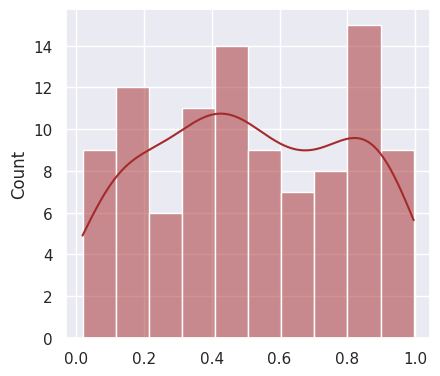

In [186]:
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    ranked = rank_transformation(cuped_df[cuped_df.group == 'A'],
                                 cuped_df[cuped_df.group == 'B'], 'cart_added_cnt_cuped')

    vec_a = ranked[(ranked['group'] == 'A')]['rank']
    vec_b = ranked[(ranked['group'] == 'B')]['rank']
    vec_b_effect = vec_b * 1.03

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
check_uniform(correctness)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

#### Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:

* на логнормальном распределении (сгенерированные данные)
* на метрике cart_added_cnt (2 балла)

In [187]:
# Генерируем логнормальное распределение
data = np.random.lognormal(0, 1, 100_000)

In [188]:
# Разбиваем данные на равные бакеты
num_buckets = 10000
sorted_data = np.sort(data)
bucket_edges = [stats.scoreatpercentile(sorted_data, i * (100 / num_buckets)) for i in range(num_buckets + 1)]
buckets = [sorted_data[(sorted_data >= bucket_edges[i]) & (sorted_data < bucket_edges[i+1])] for i in range(num_buckets)]

In [189]:
# Берем среднее значение для каждого бакета
bucket_means = [np.mean(bucket_data) for bucket_data in buckets]

In [190]:
data = pd.DataFrame({"user_id": np.arange(len(data)), "metric": data})
data_bucket_means = pd.DataFrame({"user_id": np.arange(len(bucket_means)), "metric": bucket_means})
data_bucket_means.head()

,user_id,metric
0,0,0.019604
1,1,0.026768
2,2,0.030756
3,3,0.032765
4,4,0.034948


Посомотрим на мощность без бакетирования:

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


 power: 100.0% , correctness: 96.0%


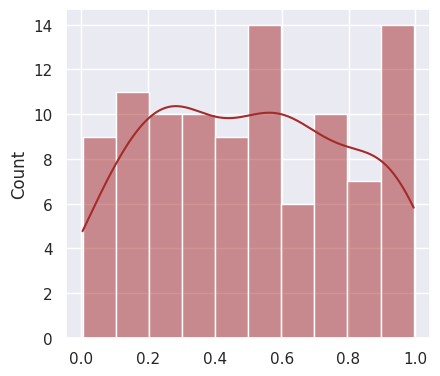

In [44]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(data.copy(), user_salt=salt_generator())
    new_df = pd.merge(data, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['metric']
    vec_b = new_df[(new_df['group'] == 'B')]['metric']

    vec_b_effect = vec_b * 1.03

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

С бакетированием:

100%|██████████| 100/100 [00:07<00:00, 14.14it/s]


 power: 57.99999999999999% , correctness: 92.0%


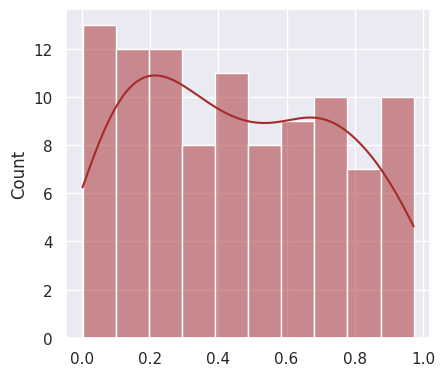

In [43]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(data_bucket_means.copy(), user_salt=salt_generator())
    new_df = pd.merge(data_bucket_means, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['metric']
    vec_b = new_df[(new_df['group'] == 'B')]['metric']

    vec_b_effect = vec_b * 1.03

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

С увеличением количества бакетов увеличивается мощность, что логично

In [191]:
def get_bucket(df, metric, bucket_size):
    df_sorted = df.sort_values(by=metric).reset_index(drop=True)
    bucket_size = len(df_sorted) // bucket_size
    df_sorted['bucket'] = pd.qcut(df_sorted.index, q=bucket_size, labels=False, duplicates='drop')

    df_sorted = df_sorted.groupby('bucket', as_index=False)[metric].mean()
    df_sorted = df_sorted.rename(columns={"bucket": "user_id"})
    return df_sorted

##### Реализовать разбивку на бакеты на метрике cart_added_cnt

In [192]:
bucket_sizes = [100, 1000, 10000]
correctness = [[] for _ in range(len(bucket_sizes))]
powers = [[] for _ in range(len(bucket_sizes))]

for idx, bucket_size in enumerate(bucket_sizes):
    shop_bucket = get_bucket(shop.copy(), 'cart_added_cnt', bucket_size)

    for i in tqdm(range(100)):

        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

        vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
        vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']

        vec_b_effect = vec_b * 1.03


        p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
        correctness[idx].append(p_cor)
        powers[idx].append(p_power)

    correctness[idx] = np.array(correctness[idx])
    powers[idx] = np.array(powers[idx])

    check_uniform(correctness[idx])
    print(f'Мощность при bucket_size = {bucket_size}: {(powers[idx][powers[idx] < 0.05].shape[0] / powers[idx].shape[0]) * 100}%')
    print(f'Корректность при bucket_size = {bucket_size}: {(1 - (correctness[idx][correctness[idx] < 0.05].shape[0] / correctness[idx].shape[0])) * 100}% \n')

100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


p_value = 0.35335432090058755 - p_values равномерное распределение
Мощность при bucket_size = 100: 34.0%
Корректность при bucket_size = 100: 94.0% 



100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


p_value = 0.9197870928891705 - p_values равномерное распределение
Мощность при bucket_size = 1000: 37.0%
Корректность при bucket_size = 1000: 97.0% 



100%|██████████| 100/100 [01:52<00:00,  1.13s/it]

p_value = 0.19548247210847067 - p_values равномерное распределение
Мощность при bucket_size = 10000: 25.0%
Корректность при bucket_size = 10000: 97.0% 



Максимальная мощность была получена при bucket_size = 1000, количество бакетов в таком случае меньше чем при bucket_size = 100, но при этом мощность была получена больше